LoRA fine-tuning with automatic relevance determination

Full rank matrix $V \in \mathbb{R}^{F \times N}$

Factorize as $V' \stackrel{\Delta}{\approx} WH$

Objective function:

$ C(W, H, \lambda) \stackrel{\Delta}{\approx} − \log p(W, H, \lambda | V) = \frac{1}{\phi} D_{\beta}(V|WH) + \sum_{k=1}^{K} \frac{1}{\lambda_k} (f(w_k) + f(h_k) + b) + c \log \lambda_k + \text{cst}$

$ C(W, H) = \frac{1}{\phi} D_{\beta}(V|WH) + c\sum_{k=1}^{K} \log (f(w_k) + f(h_k) + b) + \text{cst}$ 

$ C(W, H) = \frac{1}{\phi} D_{\beta}(V|WH) + c\sum_{k=1}^{K} \log (f(w_k) + f(h_k) + b)$

In the original ARD-NMF paper, they use a half-normal prior due to the non-negativity constraint. Here, we use a Gaussian prior. For L2 regularization, we define

$f(x) = \| x \|_2^2$

If instead we use L-1 regularization, we define

$f(x) = \| x \|_1$

We set $c = F + N + a + 1$



In [1]:
import torch
import torch.nn as nn
from torch.nn import Module
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import LambdaLR

import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from typing import Literal
from functools import partial
from tqdm.auto import tqdm

from transformers import AutoModelForSequenceClassification, AutoTokenizer
from datasets import load_dataset

In [3]:
class LoRALayer(Module):
    def __init__(
        self,
        in_dim: int,
        out_dim: int,
        init_rank: int,
        alpha: float = 1.,
        a: float = None,
        b: float = None,
        dropout: float = 0.,
        prior_A: Literal["Gaussian", "Exponential"] = "Gaussian",
        prior_B: Literal["Gaussian", "Exponential"] = "Gaussian",
        init_var: float = None
    ):
        super().__init__()
        self.init_rank = init_rank
        self.alpha = alpha
        self.scaling = alpha / init_rank
        self.dropout = dropout
        self.in_dim = in_dim
        self.out_dim = out_dim
        # Initialize a (shape) and b (scale) inverse gamma hyperparametersto defaults if not provided
        if a is None:
            a = 1
        if b is None:
            b = 1
        self.register_buffer('a', torch.tensor(a))
        self.register_buffer('b', torch.tensor(b))
        # Define norm functions
        assert prior_A in ["Gaussian", "Exponential"]
        assert prior_B in ["Gaussian", "Exponential"]
        if prior_A == "Gaussian":
            def norm_A(x):
                return 0.5 * torch.sum(x ** 2, dim=0)
        elif prior_A == "Exponential":
            def norm_A(x):
                return torch.sum(x.abs(), dim=0)
        if prior_B == "Gaussian":
            def norm_B(x):
                return 0.5 * torch.sum(x ** 2, dim=1)
        elif prior_B == "Exponential":
            def norm_B(x):
                return torch.sum(x.abs(), dim=1)
        self.norm_A = norm_A
        self.norm_B = norm_B
        # Initialize LoRA A and B matrices
        if init_var is None:
            init_var = 1 / torch.sqrt(torch.tensor(init_rank).float())
        self.lora_A = nn.Parameter(torch.randn(in_dim, init_rank) * init_var)
        self.lora_B = nn.Parameter(torch.zeros(init_rank, out_dim))
        # Initialize constants
        if (prior_A == "Gaussian") and (prior_B == "Gaussian"):
            self.register_buffer('c', torch.tensor((in_dim + out_dim) * 0.5 + (a + 1)))
        elif (prior_A == "Exponential") and (prior_B == "Exponential"):
            self.register_buffer('c', torch.tensor((in_dim + out_dim) + (a + 1)))
        elif (prior_A == "Gaussian") and (prior_B == "Exponential"):
            self.register_buffer('c', torch.tensor((in_dim * 0.5 + out_dim) + (a + 1)))
        elif (prior_A == "Exponential") and (prior_B == "Gaussian"):
            self.register_buffer('c', torch.tensor((in_dim + out_dim * 0.5) + (a + 1)))
         # Dropout
        self.dropout = nn.Dropout(p = dropout)

    def forward(self, x):
        x = self.alpha * (self.dropout(x) @ self.lora_A @ self.lora_B)
        return x

    def compute_sparsity_loss(self):
        return self.c * torch.sum( torch.log( self.norm_A(self.lora_A) + self.norm_B(self.lora_B) + self.b ) )

    def compute_lambda_k(self):
        return torch.div( (torch.sum(self.lora_A ** 2, dim=0) + torch.sum(self.lora_B ** 2, dim=1)) + self.b, self.c )

class LoRALinear(Module):
    def __init__(
        self,
        linear_layer,
        init_rank,
        alpha=1,
        a: float = None,
        b: float = None,
        dropout=0.,
        prior_A: Literal["Gaussian", "Exponential"] = "Gaussian",
        prior_B: Literal["Gaussian", "Exponential"] = "Gaussian",
        init_var: float = None,
    ):
        super().__init__()
        self.base_layer = linear_layer
        self.lora = LoRALayer(in_dim=linear_layer.in_features, out_dim=linear_layer.out_features, init_rank=init_rank, alpha=alpha, a=a, b=b,
                              dropout=dropout, prior_A=prior_A, prior_B=prior_B, init_var=init_var)

    def forward(self, x):
        return self.base_layer(x) + self.lora(x)

In [4]:
# Load pretrained model from huggingface
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2
)
for param in model.parameters():
    param.requires_grad = False

# ARD-LoRA parameters
init_rank = 32
alpha = 1
dropout = 0.1
lora_query = True
lora_key = True
lora_value = True
lora_projection = True
lora_mlp = True
lora_head = False

# LoRA assigner using default a and b values (depends on input dimensions, output dimensions, and initial rank)
assign_lora = partial(LoRALinear, init_rank=init_rank, alpha=alpha, dropout=dropout, prior_A="Gaussian", prior_B="Gaussian", a = 1, b = 1)
layers = []
avg_phi = []
for layer in model.distilbert.transformer.layer:
    if lora_query:
        phi = layer.attention.q_lin.weight.detach().cpu().numpy().flatten().var()
        layer.attention.q_lin = assign_lora(layer.attention.q_lin, init_var=phi ** 0.5)
        avg_phi.append(phi)
    if lora_key:
        phi = layer.attention.k_lin.weight.detach().cpu().numpy().flatten().var()
        layer.attention.k_lin = assign_lora(layer.attention.k_lin, init_var=phi ** 0.5)
        avg_phi.append(phi)
    if lora_value:
        phi = layer.attention.v_lin.weight.detach().cpu().numpy().flatten().var()
        layer.attention.v_lin = assign_lora(layer.attention.v_lin, init_var=phi ** 0.5)
        avg_phi.append(phi)
    if lora_projection:
        phi = layer.attention.out_lin.weight.detach().cpu().numpy().flatten().var()
        layer.attention.out_lin = assign_lora(layer.attention.out_lin, init_var=phi ** 0.5)
        avg_phi.append(phi)
    if lora_mlp:
        phi = layer.ffn.lin1.weight.detach().cpu().numpy().flatten().var()
        layer.ffn.lin1 = assign_lora(layer.ffn.lin1, init_var=phi ** 0.5)
        avg_phi.append(phi)
        phi = layer.ffn.lin2.weight.detach().cpu().numpy().flatten().var()
        layer.ffn.lin2 = assign_lora(layer.ffn.lin2, init_var=phi ** 0.5)
        avg_phi.append(phi)
if lora_head:
    phi = model.pre_classifier.weight.detach().cpu().numpy().flatten().var()
    model.pre_classifier = assign_lora(model.pre_classifier, init_var=phi ** 0.5)
    avg_phi.append(phi)
    phi = model.classifier.weight.detach().cpu().numpy().flatten().var()
    model.classifier = assign_lora(model.classifier, init_var=phi ** 0.5)
    avg_phi.append(phi)
avg_phi = np.mean(avg_phi)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, tokenizer, max_length=512):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.tokenizer(
            item['text'],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'label': item['label']
        }

# Prepare dataset
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
dataset = load_dataset('imdb')

# Initialize datasets and dataloaders
train_dataset = IMDbDataset(dataset['train'], tokenizer)
test_dataset = IMDbDataset(dataset['test'], tokenizer)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True, num_workers=4, prefetch_factor=2, persistent_workers=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False, pin_memory=True, num_workers=8, prefetch_factor=2, persistent_workers=True)

# Training config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-4)
lr_warmup_steps = 100
def lr_lambda(step):
    if step < lr_warmup_steps:
        return step / lr_warmup_steps
    else:
        return 1.0
lr_scheduler = LambdaLR(optimizer, lr_lambda)
num_epochs = 5

In [5]:
# Training loop
def train_epoch(model, data_loader, optimizer, lr_scheduler):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    # scale_divergence = 1 / phi
    progress_bar = tqdm(data_loader, desc='Training')
    n_steps = 0
    for batch in progress_bar:
        optimizer.zero_grad()
        # Move data to GPU
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        divergence = outputs.loss
        sparsity_loss = 0
        num_adapters = 0
        for layer in model.distilbert.transformer.layer:
            if lora_query:
                sparsity_loss += layer.attention.q_lin.lora.compute_sparsity_loss()
                num_adapters += 1
            if lora_key:
                sparsity_loss += layer.attention.k_lin.lora.compute_sparsity_loss()
                num_adapters += 1
            if lora_value:
                sparsity_loss += layer.attention.v_lin.lora.compute_sparsity_loss()
                num_adapters += 1
            if lora_projection:
                sparsity_loss += layer.attention.out_lin.lora.compute_sparsity_loss()
                num_adapters += 1
            if lora_mlp:
                sparsity_loss += layer.ffn.lin1.lora.compute_sparsity_loss()
                num_adapters += 1
                sparsity_loss += layer.ffn.lin2.lora.compute_sparsity_loss()
                num_adapters += 1
        loss = divergence + (sparsity_loss / num_adapters)
        # Backward pass
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        # Compute metrics
        _, preds = torch.max(outputs.logits, dim=1)
        correct += (preds == labels).sum().item()
        total_loss += loss.item()
        total += labels.size(0)
        progress_bar.set_postfix({
            'loss': total_loss / (progress_bar.n + 1),
            'acc': 100. * correct / total,
            'sparsity_loss': sparsity_loss.item(),
            'divergence': divergence.item()
        })
    return total_loss / len(data_loader), correct / total

@torch.no_grad()
def evaluate(model, data_loader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    total_sparsity_loss = 0
    total_divergence = 0
    progress_bar = tqdm(data_loader, desc='Evaluating')
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        divergence = outputs.loss
        sparsity_loss = 0
        num_adapters = 0
        for layer in model.distilbert.transformer.layer:
            if lora_query:
                sparsity_loss += layer.attention.q_lin.lora.compute_sparsity_loss()
                num_adapters += 1
            if lora_key:
                sparsity_loss += layer.attention.k_lin.lora.compute_sparsity_loss()
                num_adapters += 1
            if lora_value:
                sparsity_loss += layer.attention.v_lin.lora.compute_sparsity_loss()
                num_adapters += 1
            if lora_projection:
                sparsity_loss += layer.attention.out_lin.lora.compute_sparsity_loss()
                num_adapters += 1
            if lora_mlp:
                sparsity_loss += layer.ffn.lin1.lora.compute_sparsity_loss()
                num_adapters += 1
                sparsity_loss += layer.ffn.lin2.lora.compute_sparsity_loss()
                num_adapters += 1
        loss =  divergence + (sparsity_loss / num_adapters)
        total_loss += loss.item()
        preds = torch.argmax(outputs.logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        total_sparsity_loss += sparsity_loss.item()
        total_divergence += divergence.item()
    return total_loss / len(data_loader), correct / total, total_divergence / len(data_loader), total_sparsity_loss / len(data_loader)


In [6]:
active_thresh = 1e-6
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, lr_scheduler)
    # Evaluate
    eval_loss, eval_acc, eval_div, eval_sparsity = evaluate(model, test_loader)
    print(f"Evaluation loss: {eval_loss:.4f}, Evaluation accuracy: {eval_acc:.4f}, Evaluation sparsity: {eval_sparsity:.4f}, Evaluation divergence: {eval_div:.4f}")
    for idx, layer in enumerate(model.distilbert.transformer.layer):
        print(f"Layer {idx}")
        if lora_query:
            lambda_k = torch.div(torch.sum(layer.attention.q_lin.lora.lora_A ** 2, dim=0) + torch.sum(layer.attention.q_lin.lora.lora_B ** 2, dim=1), layer.attention.q_lin.lora.c)
            print(f"\tQuery K_eff = {sum(lambda_k >= active_thresh)}")
        if lora_key:
            lambda_k = torch.div(torch.sum(layer.attention.k_lin.lora.lora_A ** 2, dim=0) + torch.sum(layer.attention.k_lin.lora.lora_B ** 2, dim=1), layer.attention.k_lin.lora.c)
            print(f"\tKey K_eff = {sum(lambda_k >= active_thresh)}")
        if lora_value:
            lambda_k = torch.div(torch.sum(layer.attention.v_lin.lora.lora_A ** 2, dim=0) + torch.sum(layer.attention.v_lin.lora.lora_B ** 2, dim=1), layer.attention.v_lin.lora.c)
            print(f"\tValue K_eff = {sum(lambda_k >= active_thresh)}")
        if lora_projection:
            lambda_k = torch.div(torch.sum(layer.attention.out_lin.lora.lora_A ** 2, dim=0) + torch.sum(layer.attention.out_lin.lora.lora_B ** 2, dim=1), layer.attention.out_lin.lora.c)
            print(f"\tProjection K_eff = {sum(lambda_k >= active_thresh)}")
        if lora_mlp:
            lambda_k = torch.div(torch.sum(layer.ffn.lin1.lora.lora_A ** 2, dim=0) + torch.sum(layer.ffn.lin1.lora.lora_B ** 2, dim=1), layer.ffn.lin1.lora.c)
            print(f"\tMLP1 K_eff = {sum(lambda_k >= active_thresh)}")
            lambda_k = torch.div(torch.sum(layer.ffn.lin2.lora.lora_A ** 2, dim=0) + torch.sum(layer.ffn.lin2.lora.lora_B ** 2, dim=1), layer.ffn.lin2.lora.c)
            print(f"\tMLP2 K_eff = {sum(lambda_k >= active_thresh)}")


Epoch 1/5


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluation loss: -1699.8645, Evaluation accuracy: 0.5308, Evaluation sparsity: -61220.0156, Evaluation divergence: 0.6916
Layer 0
	Query K_eff = 32
	Key K_eff = 32
	Value K_eff = 25
	Projection K_eff = 23
	MLP1 K_eff = 31
	MLP2 K_eff = 22
Layer 1
	Query K_eff = 32
	Key K_eff = 32
	Value K_eff = 29
	Projection K_eff = 26
	MLP1 K_eff = 32
	MLP2 K_eff = 29
Layer 2
	Query K_eff = 32
	Key K_eff = 32
	Value K_eff = 32
	Projection K_eff = 32
	MLP1 K_eff = 32
	MLP2 K_eff = 29
Layer 3
	Query K_eff = 32
	Key K_eff = 32
	Value K_eff = 32
	Projection K_eff = 32
	MLP1 K_eff = 32
	MLP2 K_eff = 19
Layer 4
	Query K_eff = 32
	Key K_eff = 32
	Value K_eff = 32
	Projection K_eff = 32
	MLP1 K_eff = 32
	MLP2 K_eff = 23
Layer 5
	Query K_eff = 32
	Key K_eff = 32
	Value K_eff = 32
	Projection K_eff = 32
	MLP1 K_eff = 29
	MLP2 K_eff = 7
Epoch 2/5


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluation loss: -1699.9059, Evaluation accuracy: 0.5308, Evaluation sparsity: -61221.5078, Evaluation divergence: 0.6916
Layer 0
	Query K_eff = 0
	Key K_eff = 0
	Value K_eff = 0
	Projection K_eff = 0
	MLP1 K_eff = 0
	MLP2 K_eff = 0
Layer 1
	Query K_eff = 1
	Key K_eff = 0
	Value K_eff = 0
	Projection K_eff = 0
	MLP1 K_eff = 0
	MLP2 K_eff = 0
Layer 2
	Query K_eff = 0
	Key K_eff = 0
	Value K_eff = 0
	Projection K_eff = 0
	MLP1 K_eff = 0
	MLP2 K_eff = 0
Layer 3
	Query K_eff = 1
	Key K_eff = 0
	Value K_eff = 0
	Projection K_eff = 0
	MLP1 K_eff = 0
	MLP2 K_eff = 0
Layer 4
	Query K_eff = 0
	Key K_eff = 0
	Value K_eff = 0
	Projection K_eff = 0
	MLP1 K_eff = 0
	MLP2 K_eff = 0
Layer 5
	Query K_eff = 0
	Key K_eff = 0
	Value K_eff = 0
	Projection K_eff = 0
	MLP1 K_eff = 0
	MLP2 K_eff = 0
Epoch 3/5


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluation loss: -1699.9059, Evaluation accuracy: 0.5308, Evaluation sparsity: -61221.5078, Evaluation divergence: 0.6916
Layer 0
	Query K_eff = 0
	Key K_eff = 0
	Value K_eff = 0
	Projection K_eff = 0
	MLP1 K_eff = 0
	MLP2 K_eff = 0
Layer 1
	Query K_eff = 0
	Key K_eff = 0
	Value K_eff = 0
	Projection K_eff = 0
	MLP1 K_eff = 0
	MLP2 K_eff = 0
Layer 2
	Query K_eff = 0
	Key K_eff = 0
	Value K_eff = 0
	Projection K_eff = 0
	MLP1 K_eff = 0
	MLP2 K_eff = 0
Layer 3
	Query K_eff = 0
	Key K_eff = 0
	Value K_eff = 0
	Projection K_eff = 0
	MLP1 K_eff = 0
	MLP2 K_eff = 0
Layer 4
	Query K_eff = 0
	Key K_eff = 0
	Value K_eff = 0
	Projection K_eff = 0
	MLP1 K_eff = 0
	MLP2 K_eff = 0
Layer 5
	Query K_eff = 0
	Key K_eff = 0
	Value K_eff = 0
	Projection K_eff = 0
	MLP1 K_eff = 0
	MLP2 K_eff = 0
Epoch 4/5


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluation loss: -1699.9059, Evaluation accuracy: 0.5308, Evaluation sparsity: -61221.5078, Evaluation divergence: 0.6916
Layer 0
	Query K_eff = 0
	Key K_eff = 0
	Value K_eff = 0
	Projection K_eff = 0
	MLP1 K_eff = 0
	MLP2 K_eff = 0
Layer 1
	Query K_eff = 0
	Key K_eff = 0
	Value K_eff = 0
	Projection K_eff = 0
	MLP1 K_eff = 0
	MLP2 K_eff = 0
Layer 2
	Query K_eff = 0
	Key K_eff = 0
	Value K_eff = 0
	Projection K_eff = 0
	MLP1 K_eff = 0
	MLP2 K_eff = 0
Layer 3
	Query K_eff = 0
	Key K_eff = 0
	Value K_eff = 0
	Projection K_eff = 0
	MLP1 K_eff = 0
	MLP2 K_eff = 0
Layer 4
	Query K_eff = 0
	Key K_eff = 0
	Value K_eff = 0
	Projection K_eff = 0
	MLP1 K_eff = 0
	MLP2 K_eff = 0
Layer 5
	Query K_eff = 0
	Key K_eff = 0
	Value K_eff = 0
	Projection K_eff = 0
	MLP1 K_eff = 0
	MLP2 K_eff = 0
Epoch 5/5


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluation loss: -1699.9059, Evaluation accuracy: 0.5308, Evaluation sparsity: -61221.5078, Evaluation divergence: 0.6916
Layer 0
	Query K_eff = 0
	Key K_eff = 0
	Value K_eff = 0
	Projection K_eff = 0
	MLP1 K_eff = 0
	MLP2 K_eff = 0
Layer 1
	Query K_eff = 0
	Key K_eff = 0
	Value K_eff = 0
	Projection K_eff = 0
	MLP1 K_eff = 0
	MLP2 K_eff = 0
Layer 2
	Query K_eff = 0
	Key K_eff = 0
	Value K_eff = 0
	Projection K_eff = 0
	MLP1 K_eff = 0
	MLP2 K_eff = 0
Layer 3
	Query K_eff = 0
	Key K_eff = 0
	Value K_eff = 0
	Projection K_eff = 0
	MLP1 K_eff = 0
	MLP2 K_eff = 0
Layer 4
	Query K_eff = 0
	Key K_eff = 0
	Value K_eff = 0
	Projection K_eff = 0
	MLP1 K_eff = 0
	MLP2 K_eff = 0
Layer 5
	Query K_eff = 0
	Key K_eff = 0
	Value K_eff = 0
	Projection K_eff = 0
	MLP1 K_eff = 0
	MLP2 K_eff = 0


Text(0.5, 0.98, 'Distribution of LoRA weights for active vs inactive features')

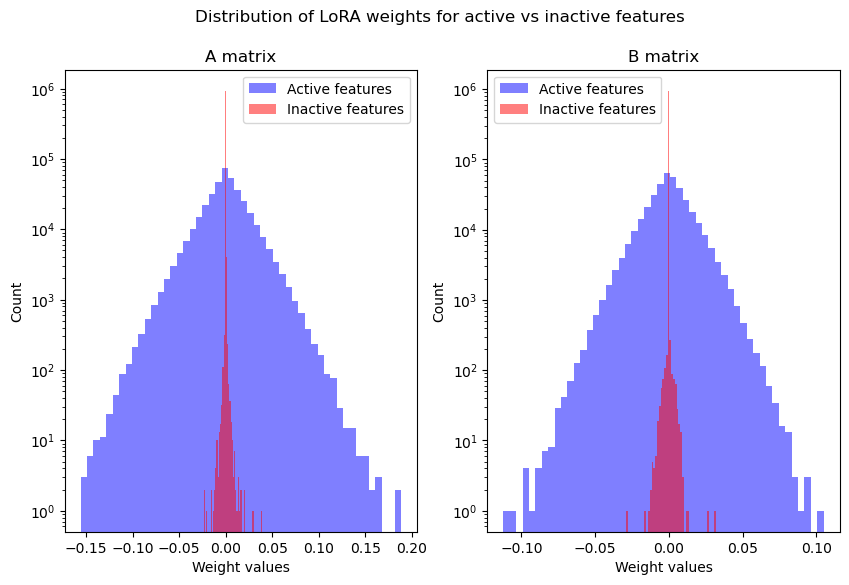

In [7]:
# Plot distribution of active features across layers
active_thresh = 1e-5
active_feature_weights_A = []
active_feature_weights_B = []
inactive_feature_weights_A = []
inactive_feature_weights_B = []
layer_indices = []
for idx, layer in enumerate(model.distilbert.transformer.layer):
    layer_indices.append(idx)
    if lora_query:
        lambda_k = torch.div(torch.sum(layer.attention.q_lin.lora.lora_A ** 2, dim=0) + 
                            torch.sum(layer.attention.q_lin.lora.lora_B ** 2, dim=1), 
                            layer.attention.q_lin.lora.c)
        active_features = (lambda_k >= active_thresh)
        active_feature_weights_A.append(layer.attention.q_lin.lora.lora_A[:, active_features].detach().cpu().numpy().flatten())
        inactive_feature_weights_A.append(layer.attention.q_lin.lora.lora_A[:, ~active_features].detach().cpu().numpy().flatten())
        active_feature_weights_B.append(layer.attention.q_lin.lora.lora_B[active_features].detach().cpu().numpy().flatten())
        inactive_feature_weights_B.append(layer.attention.q_lin.lora.lora_B[~active_features].detach().cpu().numpy().flatten())
    if lora_key:
        lambda_k = torch.div(torch.sum(layer.attention.k_lin.lora.lora_A ** 2, dim=0) + 
                            torch.sum(layer.attention.k_lin.lora.lora_B ** 2, dim=1), 
                            layer.attention.k_lin.lora.c)
        active_features = (lambda_k >= active_thresh)
        active_feature_weights_A.append(layer.attention.k_lin.lora.lora_A[:, active_features].detach().cpu().numpy().flatten())
        inactive_feature_weights_A.append(layer.attention.k_lin.lora.lora_A[:, ~active_features].detach().cpu().numpy().flatten())
        active_feature_weights_B.append(layer.attention.k_lin.lora.lora_B[active_features].detach().cpu().numpy().flatten())
        inactive_feature_weights_B.append(layer.attention.k_lin.lora.lora_B[~active_features].detach().cpu().numpy().flatten())
    if lora_value:
        lambda_k = torch.div(torch.sum(layer.attention.v_lin.lora.lora_A ** 2, dim=0) + 
                            torch.sum(layer.attention.v_lin.lora.lora_B ** 2, dim=1), 
                            layer.attention.v_lin.lora.c)
        active_features = (lambda_k >= active_thresh)
        active_feature_weights_A.append(layer.attention.v_lin.lora.lora_A[:, active_features].detach().cpu().numpy().flatten())
        inactive_feature_weights_A.append(layer.attention.v_lin.lora.lora_A[:, ~active_features].detach().cpu().numpy().flatten())
        active_feature_weights_B.append(layer.attention.v_lin.lora.lora_B[active_features].detach().cpu().numpy().flatten())
        inactive_feature_weights_B.append(layer.attention.v_lin.lora.lora_B[~active_features].detach().cpu().numpy().flatten())
    if lora_projection:
        lambda_k = torch.div(torch.sum(layer.attention.out_lin.lora.lora_A ** 2, dim=0) + 
                            torch.sum(layer.attention.out_lin.lora.lora_B ** 2, dim=1), 
                            layer.attention.out_lin.lora.c)
        active_features = (lambda_k >= active_thresh)
        active_feature_weights_A.append(layer.attention.out_lin.lora.lora_A[:, active_features].detach().cpu().numpy().flatten())
        inactive_feature_weights_A.append(layer.attention.out_lin.lora.lora_A[:, ~active_features].detach().cpu().numpy().flatten())
        active_feature_weights_B.append(layer.attention.out_lin.lora.lora_B[active_features].detach().cpu().numpy().flatten())
        inactive_feature_weights_B.append(layer.attention.out_lin.lora.lora_B[~active_features].detach().cpu().numpy().flatten())
    if lora_mlp:
        lambda_k = torch.div(torch.sum(layer.ffn.lin1.lora.lora_A ** 2, dim=0) + 
                            torch.sum(layer.ffn.lin1.lora.lora_B ** 2, dim=1), 
                            layer.ffn.lin1.lora.c)
        active_features = (lambda_k >= active_thresh)
        active_feature_weights_A.append(layer.ffn.lin1.lora.lora_A[:, active_features].detach().cpu().numpy().flatten())
        inactive_feature_weights_A.append(layer.ffn.lin1.lora.lora_A[:, ~active_features].detach().cpu().numpy().flatten())
        active_feature_weights_B.append(layer.ffn.lin1.lora.lora_B[active_features].detach().cpu().numpy().flatten())
        inactive_feature_weights_B.append(layer.ffn.lin1.lora.lora_B[~active_features].detach().cpu().numpy().flatten())
        lambda_k = torch.div(torch.sum(layer.ffn.lin2.lora.lora_A ** 2, dim=0) + 
                            torch.sum(layer.ffn.lin2.lora.lora_B ** 2, dim=1),
                            layer.ffn.lin2.lora.c)
        active_features = (lambda_k >= active_thresh)
        active_feature_weights_A.append(layer.ffn.lin2.lora.lora_A[:, active_features].detach().cpu().numpy().flatten())
        inactive_feature_weights_A.append(layer.ffn.lin2.lora.lora_A[:, ~active_features].detach().cpu().numpy().flatten())
        active_feature_weights_B.append(layer.ffn.lin2.lora.lora_B[active_features].detach().cpu().numpy().flatten())
        inactive_feature_weights_B.append(layer.ffn.lin2.lora.lora_B[~active_features].detach().cpu().numpy().flatten())

f, ax = plt.subplots(1, 2, figsize=(10, 6))
# Plot distribution of active and inactive feature weights
active_feature_weights_A = np.concatenate(active_feature_weights_A)
inactive_feature_weights_A = np.concatenate(inactive_feature_weights_A)
active_feature_weights_B = np.concatenate(active_feature_weights_B)
inactive_feature_weights_B = np.concatenate(inactive_feature_weights_B)

# Create histogram with two distributions
ax[0].hist(active_feature_weights_A, bins=50, alpha=0.5, label='Active features', color='blue')
ax[0].hist(inactive_feature_weights_A, bins=50, alpha=0.5, label='Inactive features', color='red')
ax[1].hist(active_feature_weights_B, bins=50, alpha=0.5, label='Active features', color='blue')
ax[1].hist(inactive_feature_weights_B, bins=50, alpha=0.5, label='Inactive features', color='red')

ax[0].set_xlabel('Weight values')
ax[0].set_ylabel('Count')
ax[0].legend()
ax[0].set_yscale('log')
ax[0].set_title('A matrix')
ax[1].set_xlabel('Weight values')
ax[1].set_ylabel('Count')
ax[1].legend()
ax[1].set_yscale('log')
ax[1].set_title('B matrix')
f.suptitle('Distribution of LoRA weights for active vs inactive features')

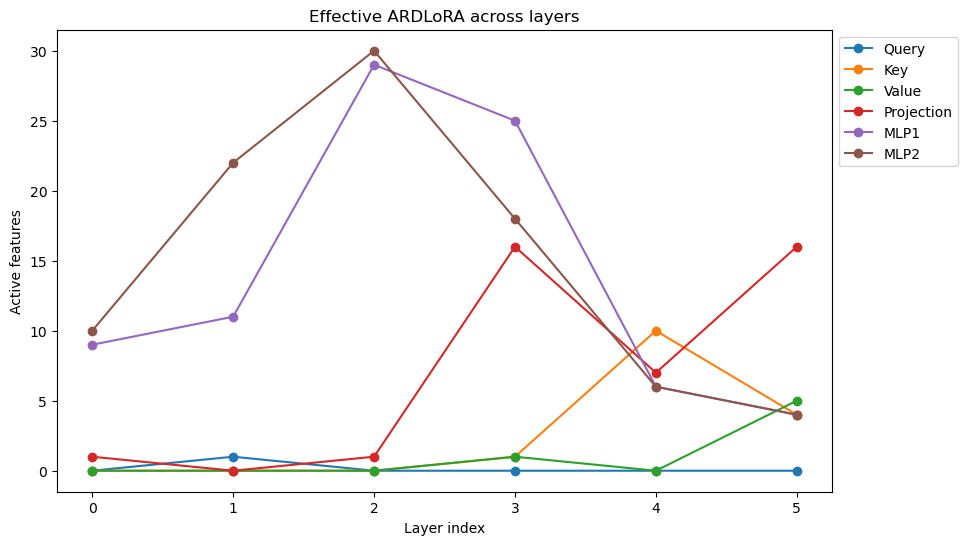

In [11]:
k_eff_data = {
    'Query': [], 'Key': [], 'Value': [], 
    'Projection': [], 'MLP1': [], 'MLP2': []
}
layer_indices = []

active_thresh = 1e-5
for idx, layer in enumerate(model.distilbert.transformer.layer):
    layer_indices.append(idx)
    if lora_query:
        lambda_k = torch.div(torch.sum(layer.attention.q_lin.lora.lora_A ** 2, dim=0) + 
                           torch.sum(layer.attention.q_lin.lora.lora_B ** 2, dim=1), 
                           layer.attention.q_lin.lora.c)
        k_eff_data['Query'].append(sum(lambda_k >= active_thresh).item())
    if lora_key:
        lambda_k = torch.div(torch.sum(layer.attention.k_lin.lora.lora_A ** 2, dim=0) + 
                            torch.sum(layer.attention.k_lin.lora.lora_B ** 2, dim=1),
                           layer.attention.k_lin.lora.c)
        k_eff_data['Key'].append(sum(lambda_k >= active_thresh).item())
    if lora_value:
        lambda_k = torch.div(torch.sum(layer.attention.v_lin.lora.lora_A ** 2, dim=0) + 
                            torch.sum(layer.attention.v_lin.lora.lora_B ** 2, dim=1),
                           layer.attention.v_lin.lora.c)
        k_eff_data['Value'].append(sum(lambda_k >= active_thresh).item())
    if lora_projection:
        lambda_k = torch.div(torch.sum(layer.attention.out_lin.lora.lora_A ** 2, dim=0) + 
                            torch.sum(layer.attention.out_lin.lora.lora_B ** 2, dim=1),
                           layer.attention.out_lin.lora.c)
        k_eff_data['Projection'].append(sum(lambda_k >= active_thresh).item())
    if lora_mlp:
        lambda_k = torch.div(torch.sum(layer.ffn.lin1.lora.lora_A ** 2, dim=0) + 
                            torch.sum(layer.ffn.lin1.lora.lora_B ** 2, dim=1),
                           layer.ffn.lin1.lora.c)
        k_eff_data['MLP1'].append(sum(lambda_k >= active_thresh).item())
        lambda_k = torch.div(torch.sum(layer.ffn.lin2.lora.lora_A ** 2, dim=0) + 
                            torch.sum(layer.ffn.lin2.lora.lora_B ** 2, dim=1),
                           layer.ffn.lin2.lora.c)
        k_eff_data['MLP2'].append(sum(lambda_k >= active_thresh).item())

plt.figure(figsize=(10, 6))
for adapter_type, k_effs in k_eff_data.items():
    if k_effs:  # Only plot if data exists for this adapter type
        plt.plot(layer_indices, k_effs, marker='o', label=adapter_type)

plt.xlabel('Layer index')
plt.ylabel('Active features')
plt.title('Effective ARDLoRA across layers')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()


Text(0.5, 1.0, 'Distribution of relevance terms')

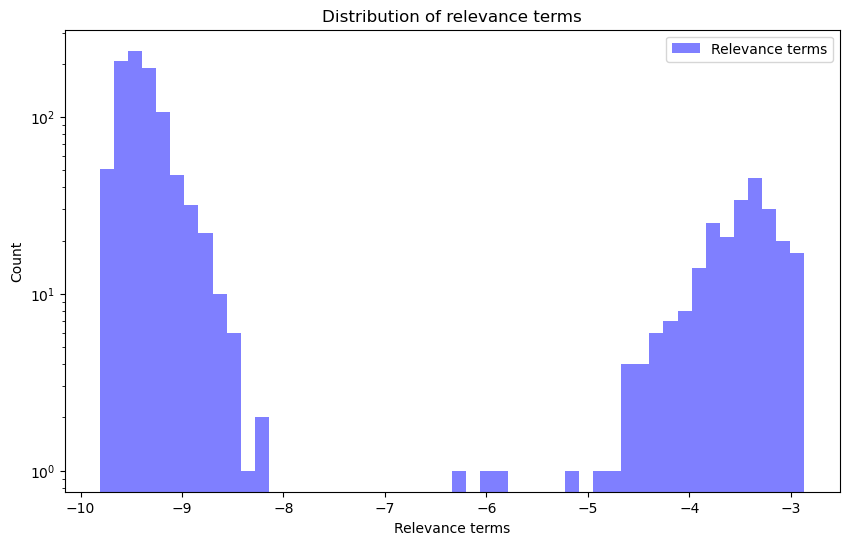

In [22]:
# Distribution of relevance terms
lambda_k_l = []
for idx, layer in enumerate(model.distilbert.transformer.layer):
    layer_indices.append(idx)
    if lora_query:
        lambda_k = torch.div(torch.sum(layer.attention.q_lin.lora.lora_A ** 2, dim=0) + 
                           torch.sum(layer.attention.q_lin.lora.lora_B ** 2, dim=1), 
                           layer.attention.q_lin.lora.c)
        lambda_k_l.append(lambda_k.detach().cpu().numpy().flatten())
    if lora_key:
        lambda_k = torch.div(torch.sum(layer.attention.k_lin.lora.lora_A ** 2, dim=0) + 
                            torch.sum(layer.attention.k_lin.lora.lora_B ** 2, dim=1),
                           layer.attention.k_lin.lora.c)
        lambda_k_l.append(lambda_k.detach().cpu().numpy().flatten())
    if lora_value:
        lambda_k = torch.div(torch.sum(layer.attention.v_lin.lora.lora_A ** 2, dim=0) + 
                            torch.sum(layer.attention.v_lin.lora.lora_B ** 2, dim=1),
                           layer.attention.v_lin.lora.c)
        lambda_k_l.append(lambda_k.detach().cpu().numpy().flatten())
    if lora_projection:
        lambda_k = torch.div(torch.sum(layer.attention.out_lin.lora.lora_A ** 2, dim=0) + 
                            torch.sum(layer.attention.out_lin.lora.lora_B ** 2, dim=1),
                           layer.attention.out_lin.lora.c)
        lambda_k_l.append(lambda_k.detach().cpu().numpy().flatten())
    if lora_mlp:
        lambda_k = torch.div(torch.sum(layer.ffn.lin1.lora.lora_A ** 2, dim=0) + 
                            torch.sum(layer.ffn.lin1.lora.lora_B ** 2, dim=1),
                           layer.ffn.lin1.lora.c)
        lambda_k_l.append(lambda_k.detach().cpu().numpy().flatten())
        lambda_k = torch.div(torch.sum(layer.ffn.lin2.lora.lora_A ** 2, dim=0) + 
                            torch.sum(layer.ffn.lin2.lora.lora_B ** 2, dim=1),
                           layer.ffn.lin2.lora.c)
        lambda_k_l.append(lambda_k.detach().cpu().numpy().flatten())
lambda_k_l = np.log10(np.concatenate(lambda_k_l))
f, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.hist(lambda_k_l, bins=50, alpha=0.5, label='Relevance terms', color='blue')
ax.set_xlabel('Relevance terms')
ax.set_ylabel('Count')
ax.legend()
ax.set_yscale('log')
ax.set_title('Distribution of relevance terms')

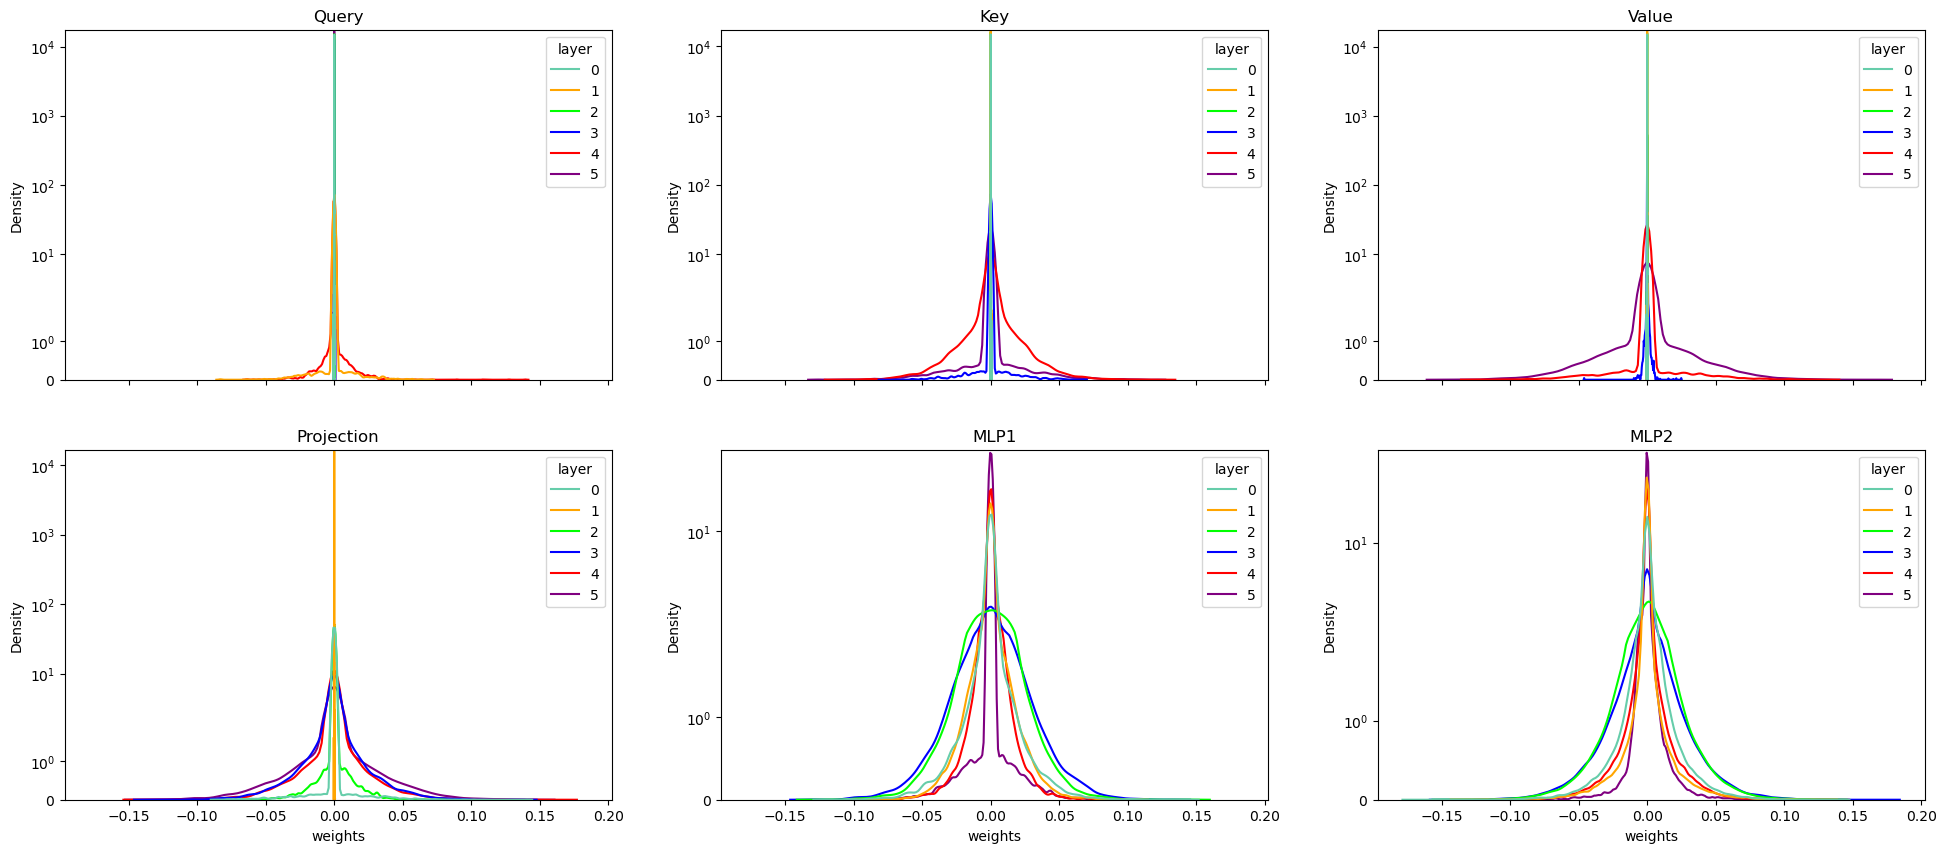

In [11]:
f, ax = plt.subplots(2, 3, figsize=(24, 10), sharex=True)
for type_idx, matrix_type in enumerate(['Query', 'Key', 'Value', 'Projection', 'MLP1', 'MLP2']):
    all_weights = []
    layer_indices = []
    for idx, layer in enumerate(model.distilbert.transformer.layer):
        if matrix_type == 'Query':
            weights = layer.attention.q_lin.lora.lora_A.detach().cpu().numpy().flatten()
        elif matrix_type == 'Key':
            weights = layer.attention.k_lin.lora.lora_A.detach().cpu().numpy().flatten()
        elif matrix_type == 'Value':
            weights = layer.attention.v_lin.lora.lora_A.detach().cpu().numpy().flatten()
        elif matrix_type == 'Projection':
            weights = layer.attention.out_lin.lora.lora_A.detach().cpu().numpy().flatten()
        elif matrix_type == 'MLP1':
            weights = layer.ffn.lin1.lora.lora_A.detach().cpu().numpy().flatten()
        elif matrix_type == 'MLP2':
            weights = layer.ffn.lin2.lora.lora_A.detach().cpu().numpy().flatten()
        all_weights.extend(weights)
        layer_indices.extend([idx] * len(weights))
    colors = ['mediumaquamarine', 'orange', 'lime', 'blue', 'red', 'purple']
    row_idx = type_idx // 3
    col_idx = type_idx % 3
    sns.kdeplot(data=pd.DataFrame({'weights': all_weights, 'layer': layer_indices}), 
                x='weights', hue='layer', palette=colors, ax=ax[row_idx, col_idx])
    ax[row_idx, col_idx].set_title(matrix_type)
    ax[row_idx, col_idx].set_yscale('symlog')

# Compare with standard LoRA

In [3]:
# Load pretrained model from huggingface
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2
)
for param in model.parameters():
    param.requires_grad = False

# ARD-LoRA parameters
init_rank = 8
alpha = 1
dropout = 0.1
lora_query = True
lora_key = True
lora_value = True
lora_projection = True
lora_mlp = True
lora_head = False

# LoRA assigner using default a and b values (depends on input dimensions, output dimensions, and initial rank)
assign_lora = partial(LoRALinear, init_rank=init_rank, alpha=alpha, dropout=dropout)
layers = []
avg_phi = []
for layer in model.distilbert.transformer.layer:
    if lora_query:
        phi = layer.attention.q_lin.weight.detach().cpu().numpy().flatten().var()
        layer.attention.q_lin = assign_lora(layer.attention.q_lin)
        avg_phi.append(phi)
    if lora_key:
        phi = layer.attention.k_lin.weight.detach().cpu().numpy().flatten().var()
        layer.attention.k_lin = assign_lora(layer.attention.k_lin)
        avg_phi.append(phi)
    if lora_value:
        phi = layer.attention.v_lin.weight.detach().cpu().numpy().flatten().var()
        layer.attention.v_lin = assign_lora(layer.attention.v_lin)
        avg_phi.append(phi)
    if lora_projection:
        phi = layer.attention.out_lin.weight.detach().cpu().numpy().flatten().var()
        layer.attention.out_lin = assign_lora(layer.attention.out_lin)
        avg_phi.append(phi)
    if lora_mlp:
        phi = layer.ffn.lin1.weight.detach().cpu().numpy().flatten().var()
        layer.ffn.lin1 = assign_lora(layer.ffn.lin1)
        avg_phi.append(phi)
        phi = layer.ffn.lin2.weight.detach().cpu().numpy().flatten().var()
        layer.ffn.lin2 = assign_lora(layer.ffn.lin2)
        avg_phi.append(phi)
if lora_head:
    phi = model.pre_classifier.weight.detach().cpu().numpy().flatten().var()
    model.pre_classifier = assign_lora(model.pre_classifier)
    avg_phi.append(phi)
    phi = model.classifier.weight.detach().cpu().numpy().flatten().var()
    model.classifier = assign_lora(model.classifier)
    avg_phi.append(phi)
avg_phi = np.mean(avg_phi)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, tokenizer, max_length=512):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.tokenizer(
            item['text'],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'label': item['label']
        }

# Prepare dataset
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
dataset = load_dataset('imdb')

# Initialize datasets and dataloaders
train_dataset = IMDbDataset(dataset['train'], tokenizer)
test_dataset = IMDbDataset(dataset['test'], tokenizer)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Training config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-4, weight_decay=0.01)
lr_warmup_steps = 500
def lr_lambda(step):
    if step < lr_warmup_steps:
        return step / lr_warmup_steps
    else:
        return 1.0
lr_scheduler = LambdaLR(optimizer, lr_lambda)
num_epochs = 5


In [5]:
# Training loop
def train_epoch(model, data_loader, optimizer, lr_scheduler):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    progress_bar = tqdm(data_loader, desc='Training')
    for batch in progress_bar:
        # Move data to GPU
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        # Compute metrics
        _, preds = torch.max(outputs.logits, dim=1)
        correct += (preds == labels).sum().item()
        total_loss += loss.item()
        total += labels.size(0)
        progress_bar.set_postfix({
            'loss': total_loss / (progress_bar.n + 1),
            'acc': 100. * correct / total,
        })
    return total_loss / len(data_loader), correct / total

@torch.no_grad()
def evaluate(model, data_loader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    progress_bar = tqdm(data_loader, desc='Evaluating')
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        preds = torch.argmax(outputs.logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return total_loss / len(data_loader), correct / total


In [6]:
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, lr_scheduler)
    # Evaluate
    eval_loss, eval_acc = evaluate(model, test_loader)
    print(f"Evaluation loss: {eval_loss:.4f}, Evaluation accuracy: {eval_acc:.4f}")



Epoch 1/5


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluation loss: 0.2352, Evaluation accuracy: 0.9062
Epoch 2/5


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluation loss: 0.2070, Evaluation accuracy: 0.9193
Epoch 3/5


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluation loss: 0.2237, Evaluation accuracy: 0.9173
Epoch 4/5


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluation loss: 0.1982, Evaluation accuracy: 0.9260
Epoch 5/5


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluation loss: 0.2018, Evaluation accuracy: 0.9258


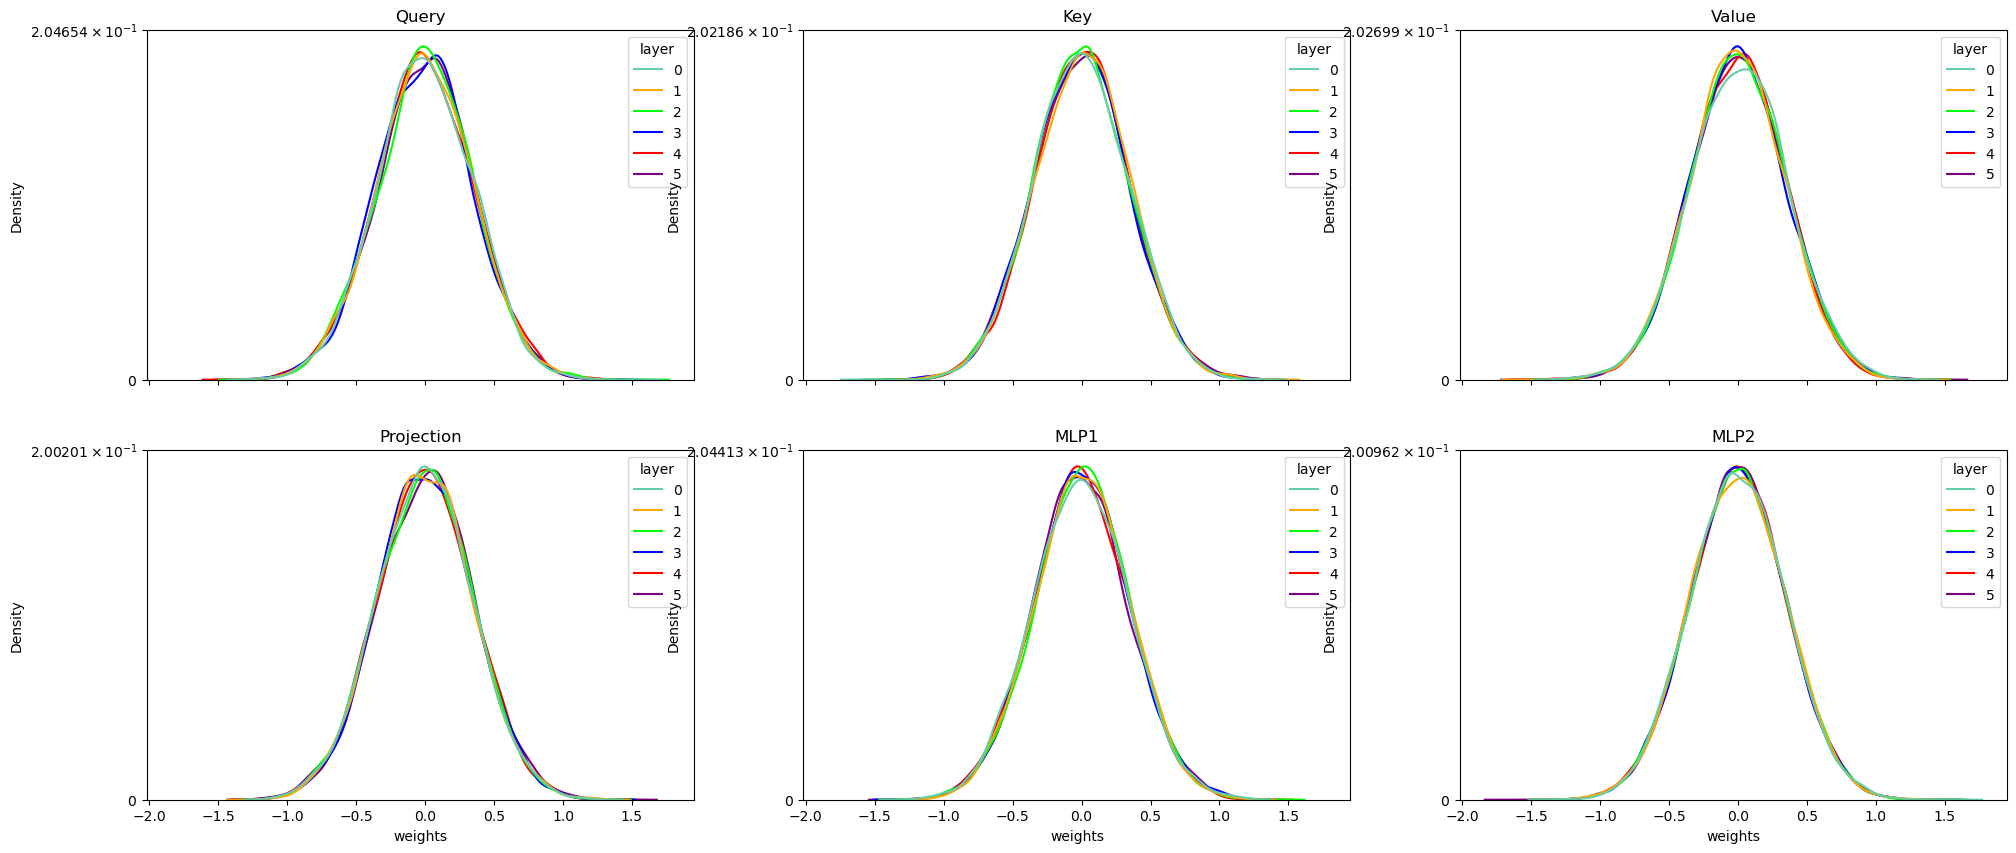

In [9]:
f, ax = plt.subplots(2, 3, figsize=(24, 10), sharex=True)
for type_idx, matrix_type in enumerate(['Query', 'Key', 'Value', 'Projection', 'MLP1', 'MLP2']):
    all_weights = []
    layer_indices = []
    for idx, layer in enumerate(model.distilbert.transformer.layer):
        if matrix_type == 'Query':
            weights = layer.attention.q_lin.lora.lora_A.detach().cpu().numpy().flatten()
        elif matrix_type == 'Key':
            weights = layer.attention.k_lin.lora.lora_A.detach().cpu().numpy().flatten()
        elif matrix_type == 'Value':
            weights = layer.attention.v_lin.lora.lora_A.detach().cpu().numpy().flatten()
        elif matrix_type == 'Projection':
            weights = layer.attention.out_lin.lora.lora_A.detach().cpu().numpy().flatten()
        elif matrix_type == 'MLP1':
            weights = layer.ffn.lin1.lora.lora_A.detach().cpu().numpy().flatten()
        elif matrix_type == 'MLP2':
            weights = layer.ffn.lin2.lora.lora_A.detach().cpu().numpy().flatten()
        all_weights.extend(weights)
        layer_indices.extend([idx] * len(weights))
    colors = ['mediumaquamarine', 'orange', 'lime', 'blue', 'red', 'purple']
    row_idx = type_idx // 3
    col_idx = type_idx % 3
    sns.kdeplot(data=pd.DataFrame({'weights': all_weights, 'layer': layer_indices}), 
                x='weights', hue='layer', palette=colors, ax=ax[row_idx, col_idx])
    ax[row_idx, col_idx].set_title(matrix_type)
    ax[row_idx, col_idx].set_yscale('symlog')
    # ax[row_idx, col_idx].set_xlim(-0.25, 0.25)

In [ ]:
# Distribution of relevance terms
lambda_k_l = []
for idx, layer in enumerate(model.distilbert.transformer.layer):
    layer_indices.append(idx)
    if lora_query:
        lambda_k = torch.div(torch.sum(layer.attention.q_lin.lora.lora_A ** 2, dim=0) + 
                           torch.sum(layer.attention.q_lin.lora.lora_B ** 2, dim=1), 
                           layer.attention.q_lin.lora.c)
        lambda_k_l.append(lambda_k.detach().cpu().numpy().flatten())
    if lora_key:
        lambda_k = torch.div(torch.sum(layer.attention.k_lin.lora.lora_A ** 2, dim=0) + 
                            torch.sum(layer.attention.k_lin.lora.lora_B ** 2, dim=1),
                           layer.attention.k_lin.lora.c)
        lambda_k_l.append(lambda_k.detach().cpu().numpy().flatten())
    if lora_value:
        lambda_k = torch.div(torch.sum(layer.attention.v_lin.lora.lora_A ** 2, dim=0) + 
                            torch.sum(layer.attention.v_lin.lora.lora_B ** 2, dim=1),
                           layer.attention.v_lin.lora.c)
        lambda_k_l.append(lambda_k.detach().cpu().numpy().flatten())
    if lora_projection:
        lambda_k = torch.div(torch.sum(layer.attention.out_lin.lora.lora_A ** 2, dim=0) + 
                            torch.sum(layer.attention.out_lin.lora.lora_B ** 2, dim=1),
                           layer.attention.out_lin.lora.c)
        lambda_k_l.append(lambda_k.detach().cpu().numpy().flatten())
    if lora_mlp:
        lambda_k = torch.div(torch.sum(layer.ffn.lin1.lora.lora_A ** 2, dim=0) + 
                            torch.sum(layer.ffn.lin1.lora.lora_B ** 2, dim=1),
                           layer.ffn.lin1.lora.c)
        lambda_k_l.append(lambda_k.detach().cpu().numpy().flatten())
        lambda_k = torch.div(torch.sum(layer.ffn.lin2.lora.lora_A ** 2, dim=0) + 
                            torch.sum(layer.ffn.lin2.lora.lora_B ** 2, dim=1),
                           layer.ffn.lin2.lora.c)
        lambda_k_l.append(lambda_k.detach().cpu().numpy().flatten())
lambda_k_l = np.log10(np.concatenate(lambda_k_l))
f, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.hist(lambda_k_l, bins=50, alpha=0.5, label='Relevance terms', color='blue')
ax.set_xlabel('Relevance terms')
ax.set_ylabel('Count')
ax.legend()
ax.set_yscale('log')
ax.set_title('Distribution of relevance terms')

Text(0.5, 1.0, 'Distribution of relevance terms')

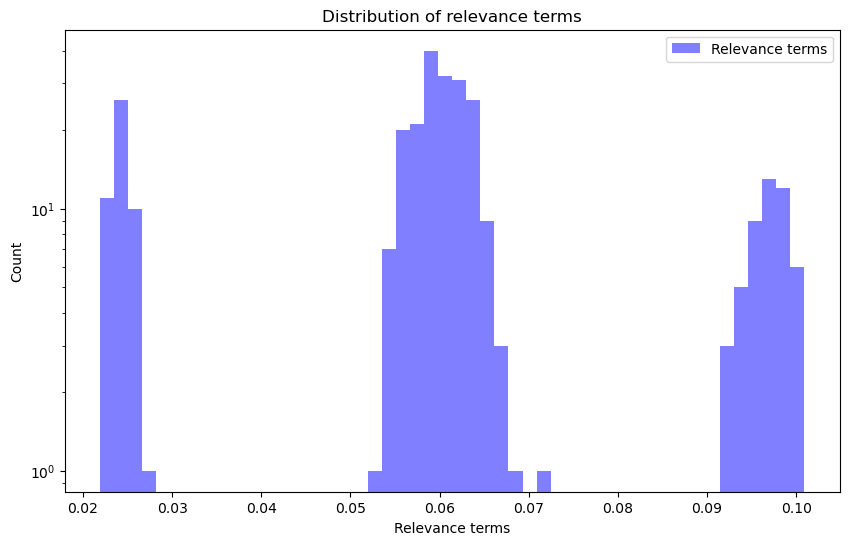

In [25]:
lambda_k_l = []
for layer in model.distilbert.transformer.layer:
    if lora_query:
        lambda_ks = (0.5 * torch.sum(layer.attention.q_lin.lora.lora_A.detach().cpu() ** 2, dim=0) + 0.5 * torch.sum(layer.attention.q_lin.lora.lora_B.detach().cpu() ** 2, dim=1)) / ((layer.attention.q_lin.lora.lora_A.shape[0] + layer.attention.q_lin.lora.lora_B.shape[1]) * 0.5 + 1 + 1)
        lambda_k_l.append(lambda_ks)
    if lora_key:
        lambda_ks = (0.5 * torch.sum(layer.attention.k_lin.lora.lora_A.detach().cpu() ** 2, dim=0) + 0.5 * torch.sum(layer.attention.k_lin.lora.lora_B.detach().cpu() ** 2, dim=1)) / ((layer.attention.k_lin.lora.lora_A.shape[0] + layer.attention.k_lin.lora.lora_B.shape[1]) * 0.5 + 1 + 1)
        lambda_k_l.append(lambda_ks)
    if lora_value:
        lambda_ks = (0.5 * torch.sum(layer.attention.v_lin.lora.lora_A.detach().cpu() ** 2, dim=0) + 0.5 * torch.sum(layer.attention.v_lin.lora.lora_B.detach().cpu() ** 2, dim=1)) / ((layer.attention.v_lin.lora.lora_A.shape[0] + layer.attention.v_lin.lora.lora_B.shape[1]) * 0.5 + 1 + 1)
        lambda_k_l.append(lambda_ks)
    if lora_projection:
        lambda_ks = (0.5 * torch.sum(layer.attention.out_lin.lora.lora_A.detach().cpu() ** 2, dim=0) + 0.5 * torch.sum(layer.attention.out_lin.lora.lora_B.detach().cpu() ** 2, dim=1)) / ((layer.attention.out_lin.lora.lora_A.shape[0] + layer.attention.out_lin.lora.lora_B.shape[1]) * 0.5 + 1 + 1)
        lambda_k_l.append(lambda_ks)
    if lora_mlp:
        lambda_ks = (0.5 * torch.sum(layer.ffn.lin1.lora.lora_A.detach().cpu() ** 2, dim=0) + 0.5 * torch.sum(layer.ffn.lin1.lora.lora_B.detach().cpu() ** 2, dim=1)) / ((layer.ffn.lin1.lora.lora_A.shape[0] + layer.ffn.lin1.lora.lora_B.shape[1]) * 0.5 + 1 + 1)
        lambda_k_l.append(lambda_ks)
        lambda_ks = (0.5 * torch.sum(layer.ffn.lin2.lora.lora_A.detach().cpu() ** 2, dim=0) + 0.5 * torch.sum(layer.ffn.lin2.lora.lora_B.detach().cpu() ** 2, dim=1)) / ((layer.ffn.lin2.lora.lora_A.shape[0] + layer.ffn.lin2.lora.lora_B.shape[1]) * 0.5 + 1 + 1)
        lambda_k_l.append(lambda_ks)
# lambda_k_l = np.log10(np.concatenate(lambda_k_l))
lambda_k_l = np.concatenate(lambda_k_l)
f, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.hist(lambda_k_l, bins=50, alpha=0.5, label='Relevance terms', color='blue')
ax.set_xlabel('Relevance terms')
ax.set_ylabel('Count')
ax.legend()
ax.set_yscale('log')
ax.set_title('Distribution of relevance terms')